In [600]:
import gymnasium as gym
from gym import ObservationWrapper
import numpy as np
from tqdm import tqdm

## Set up the Environment

In [610]:
class BattleshipsEnv(gym.Env):
    """
    Board:
        shape: (size, size)
        The values represent the tile state, which can be:
            0: water
            1: miss / no ship
            2: ship (hit)
            3: ship (hidden)

        When the board is returned, the ship (hidden) dimension is replaced by water.
    """

    metadata = {
        'render_modes': ['unicode']
    }

    WATER = 0
    NOSHIP = 1
    SHIP = 2
    SHIP_H = 3
    BOUNDARY_H = 4

    size = None
    b_num = None
    b_length = None
    
    
    def __init__(self):
        """
        Initializes the battleship game.
        Rules:
            There are b_num b_lengthx1 battleships
            These can be placed anywhere on a sizexsize board.
            Battleships cannot be placed within 1 tile of eachother.
            Initialized Tiles can be either water or ship.             
        """

        self.size = 6
        self.b_num = 3
        self.b_length = 3

        board = gym.spaces.Box(low=0, high=3, shape=(self.size, self.size), dtype=int)
        self.observation_space = board

        actions = gym.spaces.Discrete(self.size**2)
        self.action_space = actions

        self._board = None 
        self._ships = None
        self._ready = False

        self._misses = None
        self._turns = None

        

    def reset(self, seed=None, options=None):
        """
        Reset the gameboard, randomly place new ships.
        Set _ready to True
        """
        super().reset(seed=seed)

        # Initialize the b_num b_lengthx1 battleships randomly

        # Begin with empty board
        self._ready = True
        
        not_found = True
        while not_found:
            board = np.ones((self.size,self.size), dtype=int) * self.WATER
            ships = []
            for i in range(self.b_num):
                # 0 is vertical, 1 is horizontal
                orientation = self.np_random.integers(0,2)
                all_possible_pos = self._get_possible_pos(board, orientation)

                # If somehow a configuration has appeared that leaves no room
                # for this boat, then reset
                if len(all_possible_pos) == 0:
                    # print(f"ENV: No possible boat configuration {all_possible_pos}")
                    break
                
                rng_choice = self.np_random.choice(len(all_possible_pos))
                choice = all_possible_pos[rng_choice]
    
                # Add the hidden ship
                ships.append(choice)
    
                # Surround the ship with 4s to signify no placement
                surroundings = self._get_points_surrounding_ship(choice)
                board = self._alter_board(board, surroundings, self.BOUNDARY_H)
    
                # !!!TODO: Replace 3 with global variable
                board = self._alter_board(board, choice, self.SHIP_H)

                if i == (self.b_num - 1):
                    not_found = False
            


        # Wipe the filler 4 values
        board = np.where(board < self.BOUNDARY_H, board, self.WATER)
            

        self._board = board
        self._ships = ships

        self._misses = 0
        self._turns = 0

        return self._get_obs(), self._get_hidden_info() 

        
    def step(self, action):
        """
        Takes a step by targeting the location provided by the given action.
        Action is an integer in range [0, size**2]
        """

        assert self._ready, "Game is already over. Start a new game to play"

        self._turns += 1
        
        x, y = self._action_to_coord(action)
        
        reward = 0
        if self._board[y, x] == self.SHIP_H:
            reward = 0.25
            self._board[y, x] = self.SHIP

            # Should ship be cleared
            ship = self._get_ship(x, y)
            if self._ship_is_dead(ship):
                self._destroy_ship(ship)
        else:
            self._misses += 1
            self._board[y, x] = self.NOSHIP
            reward = -0.25
            

        observation = self._get_obs()
        terminated = self._game_done()
        info = self._get_hidden_info()
        if terminated:
            reward = self._get_reward()
            self._ready = False
            info["final_reward"] = reward
        truncated = False
        

        return observation, reward, terminated, truncated, info
    
    def legal_moves(self):
        """
        !!!TODO: Returns the possible legal moves as a numpy array of shape (num_legal,)
        """
        board = self._get_obs()
        # print(f"self._get_obs(): {board}")
        flat = board.reshape(-1)
        # print(f"flat: {flat}")
        # print(f"{np.argwhere(flat == 0)}")
        return np.argwhere(flat == self.WATER).squeeze(-1)

    def render(self):
        """
        !!!TODO: Prints the current visible board state
        """

        board = self._get_obs()
        print("Battleships Board")

        for row in board:
            line = []
            for val in row:
                if val == self.WATER:
                    line += ["🟦"]
                elif val == self.NOSHIP:
                    line += ["⬜"]
                elif val == self.SHIP:
                    line += ["🟥"]
            print("".join(line))

    def _get_reward(self):
        """
        Calculates the expected reward on termination
        """
        return (self.size**2 - self._turns) // 3
        # (((self.size**2) - self._misses) / self.size**2)
        # return np.sum(np.where(self._board == self.WATER, 1, 0))

    def _get_possible_pos(self, board, orientation):
        """
        Returns all possible positions a 3x1 boat with the given orientation can exist
        within on the current board.
        Return type is a numpy array of shape (n, 3, 2)
        where n is the number of valid positions, 3 represents the three tiles the ship
        occupies, and 2 represents its x and y coordinates
        """
        assert orientation in [0, 1]

        if orientation == 1:
            window_shape = (1,self.b_length)
        else: 
            window_shape = (self.b_length,1)
            
        windows = np.lib.stride_tricks.sliding_window_view(board, window_shape).squeeze()
        # print(windows)
        summed_windows = np.sum(windows, axis=-1)
        # print(summed_windows)

        # In case of ship size == size
        if summed_windows.ndim == 1:
            summed_windows = np.expand_dims(summed_windows, axis=0)
            if orientation == 1:
                summed_windows = summed_windows.T
        # print(summed_windows)
        
        list_of_pos = []
        for y, row in enumerate(summed_windows):
            for x, val in enumerate(row):
                if val == 0:
                    boat_tiles = []
                    if orientation == 1:
                        for i in range(self.b_length):
                           boat_tiles.append([x+i, y]) 
                        # boat = np.asarray([[x, y], [x+1, y], [x+2, y]])
                    else:
                        for i in range(self.b_length):
                           boat_tiles.append([x, y+i]) 
                        # boat = np.asarray([[x, y], [x, y+1], [x, y+2]])
                    boat = np.asarray(boat_tiles)
                    list_of_pos.append(boat)

        return list_of_pos

    def _get_obs(self):
        """
        Returns the current state of the board with ships hidden
        """
        return_board = self._board.copy()        
        return np.where(return_board != self.SHIP_H, return_board, self.WATER)

    def _get_hidden_info(self):
        """
        Returns the true board state
        """
        return {"h": self._board.copy(), "ships": self._ships, "legal": self.legal_moves()}

    def _alter_board(self, board, coords, value):
        """
        Alters the board at the given coordinates of shape (n, 2)
        to value v
        """

        cols = coords[:, 0]
        rows = coords[:, 1]
        select = (rows, cols)
        board[select] = value
        return board

    def _action_to_coord(self, action):
        """
        Converts an action to the coordinates it targets. 
        """
        x = action % self.size
        y = action // self.size
        return x, y

    def _game_done(self):
        """
        Returns true if no ships are left
        """
        return not bool(np.sum(np.isin(self._board, self.SHIP_H)))

    def _ship_is_dead(self, ship):
        """
        True if x,y coordinate is connected to a ship that
        has been shot down
        """
        
        for s_x, s_y in ship:
            if self._board[s_y, s_x] == self.SHIP_H:
                return False
        return True


    def _get_ship(self, x, y):
        """
        Returns the associated ship to the coordinates x,y
        !!!TODO
        """

        for ship in self._ships:
            for s_x,s_y in ship:
                if (x,y) == (s_x,s_y):
                    return ship
        return None

    def _get_surrounding_coordinates(self, x, y):
        """
        Returns a list of tuples of the surrounding coordinates
        of an x,y coordinate
        """
        edge = self.size - 1
        coords = []
        if x > 0: coords.append((x-1, y))                
        if x < edge: coords.append((x+1, y))
        if y > 0: coords.append((x, y-1))
        if y < edge: coords.append((x, y+1))

        if x > 0 and y > 0: coords.append((x-1, y-1))
        if x > 0 and y < edge: coords.append((x-1, y+1))
        if x < edge and y > 0: coords.append((x+1, y-1))
        if x < edge and y < edge: coords.append((x+1, y+1))
        
        return coords

    def _get_points_surrounding_ship(self, ship):
        """
        Returns all the points surrounding and including a given 
        ship of shape (_b_length,2) where _b_length is the length, and 2 refers 
        to the x,y coordinates of each tile on the ship
        """
        all_coords = []
        for s_x,s_y in ship:
            surround = self._get_surrounding_coordinates(s_x, s_y)
            all_coords.extend(surround)

        
        all_coords = [list(i) for i in set(map(tuple, all_coords))]
        return np.asarray(all_coords)
            
    def _destroy_ship(self, ship):
        """
        !!!TODO
        """
        all_coords = self._get_points_surrounding_ship(ship)
        self._board = self._alter_board(self._board, all_coords, self.NOSHIP)

gym.register(
    id="BattleshipsEnv-v0",
    entry_point=BattleshipsEnv,
)

/Users/bjornholst/opt/miniconda3/envs/torch_env2/lib/python3.9/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment BattleshipsEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [611]:
class FlatEncoded(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        size = env.observation_space.shape[0]
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(size*size*3,), dtype=bool)

    def observation(self, obs):
        num_unique = 3
        out = np.zeros(obs.shape + (num_unique,), bool)
        out[(*np.indices(obs.shape, sparse=True), obs)] = True
        flat = out.reshape(-1)
        return flat

In [612]:
def coord_to_action(x, y, size):
        """
        Converts a coordinate to an action
        """
        return y*size + x

In [613]:
test_env = gym.make("BattleshipsEnv-v0")
test_env = FlatEncoded(test_env)

In [614]:
state, info = test_env.reset(seed=420)
info

{'h': array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 3, 3, 3],
        [3, 0, 0, 0, 0, 0],
        [3, 0, 3, 3, 3, 0],
        [3, 0, 0, 0, 0, 0]]),
 'ships': [array([[2, 4],
         [3, 4],
         [4, 4]]),
  array([[0, 3],
         [0, 4],
         [0, 5]]),
  array([[3, 2],
         [4, 2],
         [5, 2]])],
 'legal': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35])}

In [615]:
test_env.reset()

(array([ True, False, False,  True, False, False,  True, False, False,
         True, False, False,  True, False, False,  True, False, False,
         True, False, False,  True, False, False,  True, False, False,
         True, False, False,  True, False, False,  True, False, False,
         True, False, False,  True, False, False,  True, False, False,
         True, False, False,  True, False, False,  True, False, False,
         True, False, False,  True, False, False,  True, False, False,
         True, False, False,  True, False, False,  True, False, False,
         True, False, False,  True, False, False,  True, False, False,
         True, False, False,  True, False, False,  True, False, False,
         True, False, False,  True, False, False,  True, False, False,
         True, False, False,  True, False, False,  True, False, False]),
 {'h': array([[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 3, 0, 0],
         [0, 3, 0, 3, 0, 0],
         [0, 3, 0, 3, 0, 0],
         [0, 3, 0, 0, 0, 

In [616]:
_, reward, _, _, hidden = test_env.step(0) # coord_to_action(4,5)

In [617]:
test_env.render()

Battleships Board
⬜🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦


In [618]:
hidden

{'h': array([[1, 0, 0, 0, 0, 0],
        [0, 0, 0, 3, 0, 0],
        [0, 3, 0, 3, 0, 0],
        [0, 3, 0, 3, 0, 0],
        [0, 3, 0, 0, 0, 0],
        [0, 0, 0, 3, 3, 3]]),
 'ships': [array([[3, 1],
         [3, 2],
         [3, 3]]),
  array([[1, 2],
         [1, 3],
         [1, 4]]),
  array([[3, 5],
         [4, 5],
         [5, 5]])],
 'legal': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35])}

### Set up the RL

In [619]:
from collections import namedtuple, deque
import random
import torch.nn as nn
import torch
import torch.nn.functional as F
from itertools import count
import math
import matplotlib
import matplotlib.pyplot as plt

In [620]:
# torch.backends.mps.is_available()

In [626]:
env = FlatEncoded(gym.make("BattleshipsEnv-v0"))
device = "cpu" # "mps:0"
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward", "illegal"))
class ReplayMemory(object):
    """
    Provides an interface for the ReplayMemory, allowing the DQN
    to replay previous training steps.
    """
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [627]:
class DQN(nn.Module):
    """
    The network used for our DQN model
    Structure:
        Linear Layer (n_observations, 256)
        Relu
        Linear Layer (256, 256)
        Relu
        Linear Layer (256, n_actions)
    """

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 768)
        self.layer2 = nn.Linear(768, 768)
        self.layer3 = nn.Linear(768, n_actions)

    def forward(self, X):
        out1 = F.relu(self.layer1(X))
        out2 = F.relu(self.layer2(out1))
        out3 = self.layer3(out2)
        return out3

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
LR_DECAY = 1e-5

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True, weight_decay=LR_DECAY) # weight_decay=LR_DECAY
memory = ReplayMemory(30100)
steps_done = 0

def select_action(state, legal_moves):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            policy_choices = policy_net(state)
            return legal_moves[policy_choices[legal_moves].argmax(-1)].view(1, 1)
    else:
        random_index = torch.randint(0, len(legal_moves), (1,))
        random_move = legal_moves[random_index] 
        return torch.tensor([[random_move.item()]], device=device, dtype=torch.long)
        # return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []

In [628]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return None

    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])
    # print(f"non_final_mask.shape {non_final_mask.shape}")

    # print(f"non_final_next_states.shape {non_final_next_states.shape}")

    # print(f"batch_state {batch.state}")
    # print(f"type(batch_state) {type(batch.state)}")
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # print(f"action_batch.shape {action_batch.shape}")
    # print(f"reward_batch.shape {reward_batch.shape}")

    # print(f"state_batch.shape() {state_batch.shape}")
    # print(f"state_batch {state_batch}")
    # print(f"policy_net(state_batch).shape: {policy_net(state_batch).shape}")

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    
    # print(f"target_net(non_final_next_states).shape {target_net(non_final_next_states).shape}")
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # print(non_final_next_states.shape)
    # print(target_net(non_final_next_states).shape)
    # print(target_net(non_final_next_states).max(1))
    # print(target_net(non_final_next_states).max(1).values.shape)
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # print(f"expected_state_action_values {expected_state_action_values.unsqueeze(1).shape}")
    # print(f"state_action_values {state_action_values.shape}")
    
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    # assert False
    # print(loss.item())

    # Illegal move loss
    policy_out = policy_net(state_batch)
    
    mask = torch.ones_like(policy_out, dtype=torch.bool)
    # Mask out illegal moves by setting corresponding indices to False
    for i, illegal in enumerate(batch.illegal):
        mask[i, illegal] = False
    
    illegal_policy_out = policy_out[~mask]
    illegal_criterion = nn.MSELoss()
    illegal_loss = illegal_criterion(illegal_policy_out, torch.zeros_like(illegal_policy_out))

    # Optimize again against illegal moves
    optimizer.zero_grad()
    illegal_loss.backward()
    optimizer.step()
    
    return loss.item()

In [629]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    losses_t = torch.tensor(losses, dtype=torch.float)
    # rewards_t = torch.tensor(print_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

        means_l = losses_t.unfold(0, 100, 1).mean(1).view(-1)
        means_l = torch.cat((torch.zeros(99), means_l))
        plt.plot(means_l.numpy())

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

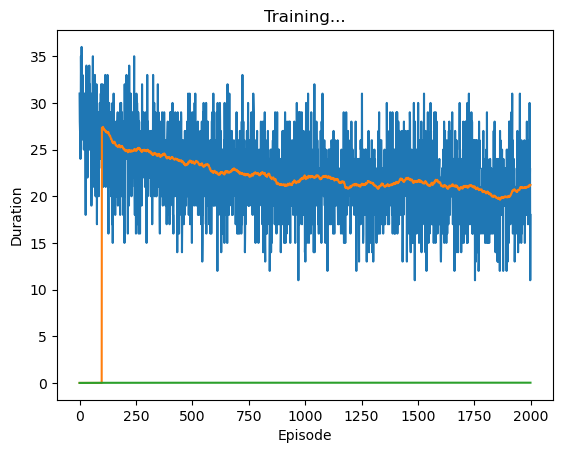

In [630]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 2000
else:
    num_episodes = 50

losses = []
rewards = [0]
print_rewards = []
for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset() # seed = 420
    state = torch.tensor(state, dtype=torch.float32, device=device)

    # All moves legal
    legal_moves = torch.tensor(np.arange(n_actions), device=device)
    illegal_moves = torch.tensor([], device=device)

    episode_losses = []
    num_loss = 0
    for t in count():
        # input("next move")
        action = select_action(state, legal_moves)
        observation, reward, terminated, truncated, hidden_info = env.step(action.item())

        # Subtract the average reward from reward to incentivize high-reward play
        # avg_reward = sum(rewards) / len(rewards)
        # if reward:
            # reward = torch.tensor([reward - avg_reward], device=device)
        # else:
        reward = torch.tensor([reward], device=device)
        
        done = terminated or truncated

        illegal_moves = torch.arange(n_actions, device=device)
        illegal_mask = ~torch.isin(illegal_moves, legal_moves)
        illegal_moves = illegal_moves[illegal_mask]
        legal_moves = torch.tensor(hidden_info["legal"], device=device)

        if terminated:
            next_state = None
            rewards.append(reward)
            # print_rewards.append(reward - avg_reward)
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        
        
        # Store the transition in memory
        memory.push(state, action, next_state, reward, illegal_moves)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model()
        if loss:
            num_loss += 1
            episode_losses.append(loss)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            assert t <= n_actions
            episode_durations.append(t + 1)
            if num_loss:
                losses.append(sum(episode_losses) / num_loss)
            else:
                losses.append(0)
            plot_durations()
            break

### Example Inference

In [633]:
legal_moves = torch.tensor(np.arange(n_actions), device=device)
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device)
env.render()
count1=0

while True:
    policy_choices = policy_net(state)
    print(policy_choices)
    action = legal_moves[policy_choices[legal_moves].argmax(-1)].view(1, 1)
    observation, reward, terminated, truncated, hidden_info = env.step(action.item())
    env.render()
    print(count1, f"reward: {reward}")
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated
    legal_moves = torch.tensor(hidden_info["legal"], device=device)

    count1 += 1
    
    if terminated:
        next_state = None
        break
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device)
    
    # Move to the next state
    state = next_state
    

print(count1)

Battleships Board
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
tensor([5.5703, 5.5959, 5.7804, 5.8475, 5.7677, 5.7958, 5.5519, 5.5860, 5.6454,
        5.4574, 5.8054, 5.5727, 5.8318, 5.7109, 5.8017, 5.5880, 5.9195, 5.8325,
        5.8188, 5.7725, 5.6022, 5.8086, 5.6441, 5.8824, 5.6885, 5.6651, 5.6715,
        5.7861, 5.7546, 5.6736, 5.6367, 5.8334, 5.7488, 5.6159, 5.6738, 5.5371],
       grad_fn=<ViewBackward0>)
Battleships Board
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦⬜🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
0 reward: -0.25
tensor([5.6081, 5.4984, 5.9170, 6.0190, 5.6980, 5.7419, 5.7158, 5.7289, 5.7189,
        5.5842, 5.9210, 5.6958, 5.7866, 5.6476, 5.7712, 5.5878, 0.2108, 5.7008,
        5.9440, 5.8296, 5.5228, 5.9885, 5.5980, 5.9608, 5.7122, 5.6713, 5.6726,
        5.8040, 5.7302, 5.5684, 5.6828, 5.9494, 5.5702, 5.7538, 5.6512, 5.6446],
       grad_fn=<ViewBackward0>)
Battleships Board
🟦🟦🟦⬜🟦🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦⬜🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦
1 reward: -0.25
tensor([5.9225, 5.5082, 5.9729, 0.0555, 5.8789, 5.7302, 5.6865, 5.6515, 5.8317,
  

In [ ]:
def super_ai():
    """
    !!!TODO:
    """

In [ ]:
def random_ai():
    """
    !!!TODO:
    """